## Prediction Model of Walmart Sales Data with SARIMAX

## <u>Table of Contents</u>

#### Problem Overview

#### Part I.  Data Exploration
    1.1.  Imports
    1.2.  Loading Datasets and First Look
    1.3.  Dataset Pre-processing
    1.4.  Preliminary Plot
    1.5.  Preparing Dataframe for Targeted Departments
    1.6.  Part Summary
    
#### Part II.  SARIMA Modeling
    2.1.  Model Identification
    2.2.  Parameter Estimation
    2.3.  Model Fitting and Validation
    2.4.  In-Sample Prediction and Evaluation
    2.5.  Dynamic Prediction
    2.5.  Part Summary
    
#### Part III.  SARIMAX Modeling with Exogenous Variables
    3.1.  Exploring Features
    3.2.  Adding Variable "Holiday"
    3.3.  Adding Variable "Fuel_Price"
    
#### Part IV.  Forecasting Out of Sample
    4.1.  Forecasting Next Two Years
    4.2.  Future Work

## <u>Problem Overview</u>
Accurate sales forecasting allows large retail stores like Walmart to manage inventory, predict revenue, and make informed decisions regarding new investments. The goal of this project is to develop a model that can forecast store sales based on past sales patterns.

## <u>Part I. Data Exploration</u>

### Section 1.1.  Imports

In [1]:

# !pip install pmdarima     # if not installed already

# Importing libraries
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pmd

### Section 1.2.  Loading Datasets and First Look

In [2]:
# Loading the 4 files as dataframes
df_features = pd.read_csv("features.csv")
df_store = pd.read_csv("stores.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Changing setting to display max columns
pd.pandas.set_option('display.max_columns', None)

In [4]:
# df_features.info()

In [4]:
# df_features.head()

In [7]:
# df_features.tail()

In [8]:
# df_store.info()

In [1]:
# df_store.head()

In [10]:
# df_store.tail()

In [27]:
# df_store.describe()

In [11]:
# df_train.info()

In [14]:
# df_train.head()

In [15]:
# df_train.tail()

In [66]:
# df_train.describe()

In [16]:
# df_test.info()

In [17]:
# df_test.head()

In [18]:
# df_test.tail()

#### <b>Observations:</b>

From the "train" dataframe, some sales numbers are negative. We do not know exactly what the negative sales indicate. 
The current approach is to keep these numbers in place.





### Section 1.3.  Dataset Pre-Processing

#### Cleaning "Store" and "train" Datasets

In [ ]:
# Checking for duplicates.  
# In any given week, there can only be one date, and it must be a Friday.
# In any given week, one store-deptmt combo can have at most 1 weekly sales number.

In [19]:
# checking for missing values
# sum_missing_store = df_store.isnull().sum()
# sum_missing_train = df_train.isnull().sum()
# print (sum_missing_store)
# print (sum_missing_train)

#### Merging "Store" and "Train"
By merging "Store" and "Train", we create a new dataframe linking each department sales number with its corresponding store type. 

In [9]:
# creating new dataframe from merging df_store and df_train
df_train_store = pd.merge(df_train,df_store,on='Store',how='left')
#df_train_store.head()

In [10]:
# converting 'Date' column to datetime format
df_train_store['Date'] = pd.to_datetime(df_train_store['Date'])
# adding 'month' and 'year' columns
#df_train_store['month'] = df_train_store['Date'].dt.month 
#df_train_store['year'] = df_train_store['Date'].dt.year

# seeting 'Date' as new index
df_train_store.set_index('Date', inplace=True)

In [9]:
# Checking the newly merged dataframe
# df_train_store.head()
# df_train_store.info()

### Section 1.4.  Preliminary Plot

We have a first look of the average weekly sales per department, of all departments over the 2 year period, separated by store type.

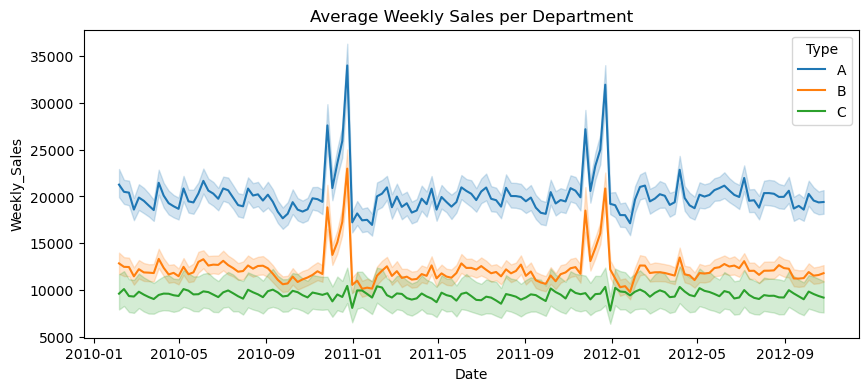

In [7]:
# Using line plot to show the average weekly sales per department.  Each store type is shown separately.
plt.figure(figsize=(10,4))
sns.lineplot(data=df_train_store, 
             x='Date', 
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Average Weekly Sales per Department')
plt.show()

#### Observations and Plans:
The Walmart stores are categorized into 3 store types with large, medium, and small sizes, respectively.  To build an effective time series model, it is important to maintain consistency in both the content and nature of the data across all dates. For this project, we will analyze the data from each store type separately, beginning with Type A large-size stores.

### Section 1.5.  Preparing Dataframe for Targeted Departments

In [12]:
# Separating into three dataframes, one for each store type
df_typeA = df_train_store[df_train_store['Type']=='A'].copy()
df_typeB = df_train_store[df_train_store['Type']=='B'].copy()
df_typeC = df_train_store[df_train_store['Type']=='C'].copy()

Before modeling of store type A, we must decide whether to include all of its stores and departments.  
We check the data to see if each department has missing dates.


In [13]:
# Combining Store and Department ID to make a new column, giving each department a unique string-type ID, for convenience.
df_typeA['StoreDept'] = 'S' + df_typeA['Store'].astype(str) + 'D' + df_typeA['Dept'].astype(str)
df_typeA.tail()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,StoreDept
Date,,,,,,,
2012-09-14,41,99,0.10,False,A,196321,S41D99
2012-09-21,41,99,0.08,False,A,196321,S41D99
2012-10-05,41,99,934.88,False,A,196321,S41D99
2012-10-12,41,99,230.03,False,A,196321,S41D99
2012-10-26,41,99,29.88,False,A,196321,S41D99


#### Checking Number of Appearences of Each Department

There are a total of 143 weeks in the time series.  Each department can have a maximum of 143 appearences, if the department's data is completely recorded.

In [15]:
typeA_dept_count = df_typeA['StoreDept'].value_counts()
print(typeA_dept_count)

StoreDept
S1D1      143
S40D94    143
S27D74    143
S27D72    143
S27D71    143
         ... 
S33D71      1
S13D43      1
S36D99      1
S33D27      1
S27D39      1
Name: count, Length: 1671, dtype: int64


In [16]:
typeA_dept_count.value_counts()

count
143    1399
1        12
2        11
4        10
5         8
       ... 
89        1
90        1
27        1
92        1
67        1
Name: count, Length: 103, dtype: int64

#### Observations and Dealing with Missing Data

Out of the 1617 departments, 1399 departments have data appearing in all 143 weeks, giving a complete record of weekly sales. Some departments have very limited data, with 12 of them appearing in as few as only 1 week.<br>
Each individual department's sales amount is different in nature, as they sell a unique type of product. In order to ensure data consistency, we must keep each week's total sales amount coming from the exact same departments in the same stores.<br>
Since the "completely recorded" departments represent a majority of all departments, we choose to use only these departments as our target departments for model fitting, and omit the departments with missing data. <br>

#### Creating Dataframe of Target Departments

In [17]:
# Obtaining indices of departments with maximum 143 appearences
target_depts = typeA_dept_count[(typeA_dept_count == 143)].index

# Creating new dataframe to include only the "completely recorded" departments
df_typeA_target = df_typeA[df_typeA['StoreDept'].isin(target_depts)]
df_typeA_target.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,StoreDept
Date,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,S1D1
2010-02-12,1,1,46039.49,True,A,151315,S1D1
2010-02-19,1,1,41595.55,False,A,151315,S1D1
2010-02-26,1,1,19403.54,False,A,151315,S1D1
2010-03-05,1,1,21827.90,False,A,151315,S1D1


Since the number of targeted departments remain constant in each date, there will not be any modeling difference between using "average" or "total" weekly sales.  
Here we choose "total weekly sales" as our main value to model.


In [18]:
# get the weekly sales sum from all 1399 targeted departments in each week.
sums_typeA = df_typeA_target.groupby('Date')['Weekly_Sales'].sum()
df_sums_typeA = sums_typeA.round(2).to_frame()
df_sums_typeA.rename(columns={'Weekly_Sales': 'Weekly_Total_Sales'}, inplace=True)
df_sums_typeA.head()

,Weekly_Total_Sales
Date,
2010-02-05,31992132.43
2010-02-12,30630927.36
2010-02-19,30712605.38
2010-02-26,27960416.70
2010-03-05,29975879.01


This is our prepared time series data, to be modeled in Part 2.

### Section 1.6.  Part Conclusion

## <u>Part II.  SARIMA Modeling</u>


This part covers the modeling of Total Weekly Sales of the 1399 Target Departments within Store Type A.<br>
The modeling process follows the Box-Jenkins method, with a 3-stage approach:
#####    1. Model identification
#####    2. Parameter selection
#####    3. Model validation

### Section 2.1.  Model Identification

#### Plot of Weekly Total Sales of Target Departments

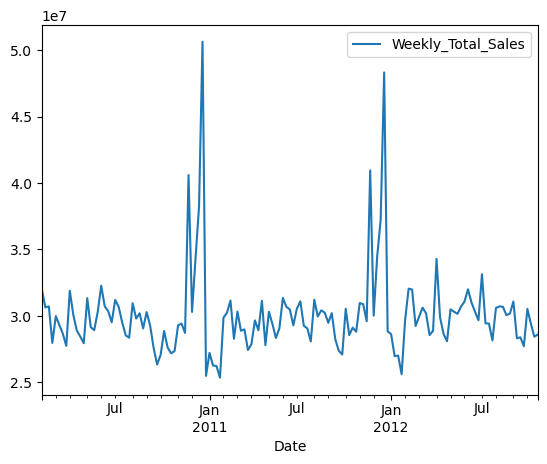

In [15]:
df_sums_typeA.plot()
plt.show()

#### ACF and PACF Plots for Examination

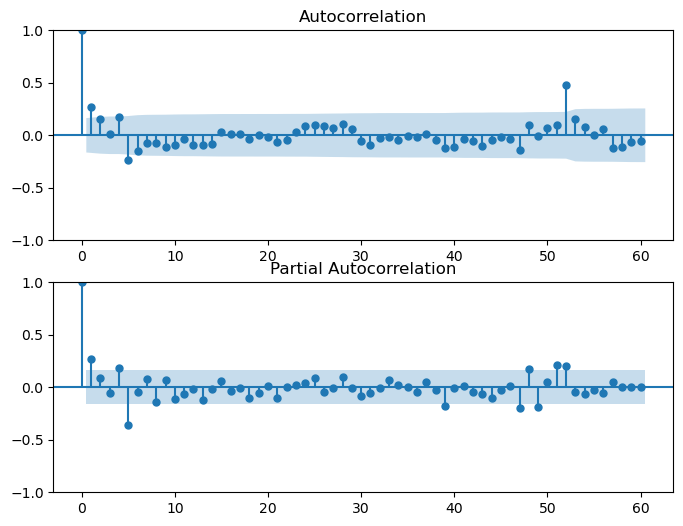

In [16]:
# Using max 60 lags, considering potential 52 week seasonality
Fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
plot_acf(df_sums_typeA, lags = 60, ax = ax1)
plot_pacf(df_sums_typeA, lags = 60, ax = ax2)
plt.show()

#### Identifying Seasonality
By observing the "spikes" in the plot, and considering that the data represents retail sales amounts, it is safe to determine that the data's behavior has the seasonality of one year, tied with customers' buying habits fluctuating on an annual basis.<br>
For seasonal data, a SARIMA model is to be implemented.


#### Checking for Stationarity

In [17]:
# Using AD-Fuller test to check for stationarity
adf_result_A = adfuller(df_sums_typeA)
print (adf_result_A)
# Testing each store type separately

(-5.877616911205699, 3.13246599835872e-07, 4, 138, {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}, 4191.60151196997)


<b>Interpretations: </b> <br>
With a near zero p-value, the weekly sales passes the ad-fuller test. <br>
The data appearing stationary while we observe an obvious seasonal pattern, indicating that:
- The seasonal pattern is repeating and stable (same shape, amplitude across time) 
- The spikes don’t grow in magnitude over time (seasonality is additive, not multiplitive)
- There’s no underlying drift/trend pushing the mean upward or downward indefinitely.

#### Seasonal Decomposition

Applying a Seasonal Decomposition to break down the data into 3 components:  Seasonality, Trend, Residual. <br><br>
We use 52 as the seasonal period, for the scope of this project.  The accurate number of weeks in a year is not exactly 52, and there might be slight variance in the model caused by the varying number of weeks in a year.


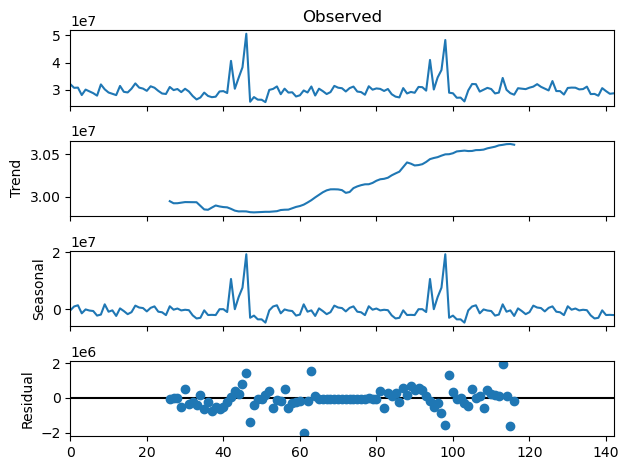

In [18]:
df_sums_typeA_decomposed = seasonal_decompose(df_sums_typeA.values, period=52) 
df_sums_typeA_decomposed.plot()
plt.show()


<b>Observation: </b><br>
Aside from "Seasonal" component, the data shows a positive trend in the "Trend" component.  Both Seasonality and Trend should be addressed in the SARIMA model.<br>


### Section 2.2. Parameter Estimation with Auto ARIMA

Auto ARIMA procedure is to be implemented.  Auto ARIMA iterates through different parameter values to find optimal ones to input into SARIMA model.

AIC is to be minimized. AIC is a criterion to be used instead of BIC, because the ultimate goal of the model is more predictive than descriptive.  

SARIMA model:  (p,d,q)(P,D,Q,S)

Ranges of values of "p", "q", "P", "Q", are to be interated and individually tested.  Common practice is to test all integers from 0 to 3. 
The seasonal period, "S", is to be set to 52.

The normal differencing factor, "d", indicates the level of differencing addressing the non-seasonal "Trend" component. Common practice is that d <= 1.  Because of the positive trend seen in the decomposing graph, it is determined that d = 1. 

The seasonal differencing factor, "D", indicates the level of differencing addressing the "Seasonal" component.  Common practice is that D <= 1.  Since the data's seasonality pattern is too strong to be ignored, it is safe to determine that D = 1.




#### Section 2.2.1  Auto ARIMA

In [30]:
# unsure of whether normal differencing is needed.  also trying d=1.
auto_arima_d1 = pmd.auto_arima(df_sums_typeA,
                                    d=1,
                                    start_p=1,  # it seems starting at 0 is the same as 1?
                                    start_q=1,
                                    max_p=3,
                                    max_q=3,
                                    seasonal=True,
                                    m=52,
                                    D=1,
                                    start_P=1,
                                    start_Q=1,
                                    max_P=3,
                                    max_Q=3,
                                    information_criterion='aic',  # aic is better than bic for predictive models
                                    trace=True,    # print results while training
                                    stepwise=True    # apply intelligent order search
                                    )
print(auto_arima_d1.summary())
#auto_arima_d1.plot_diagnostics()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Time=21.20 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2828.115, Time=0.79 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2802.999, Time=4.65 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2801.530, Time=6.19 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2812.334, Time=1.62 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=17.96 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2793.887, Time=27.31 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=2795.886, Time=15.84 sec
 ARIMA(0,1,1)(0,1,3)[52]             : AIC=2795.886, Time=40.41 sec
 ARIMA(0,1,1)(1,1,3)[52]             : AIC=2797.886, Time=28.42 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=2803.217, Time=19.02 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=2795.534, Time=31.80 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=2796.721, Time=19.53 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=2795.716, Time=14.18 sec
 ARIMA(1,1,2)(0,1,2

### Section 2.3.  Model Fitting and Validation

In [24]:
# Using SARIMA model without exogenous variables to fit
model_sums_typeA = SARIMAX(df_sums_typeA, order=(0,1,1), seasonal_order = (0,1,2,52))
result_SA = model_sums_typeA.fit()

C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#### Plot Diagnostics:

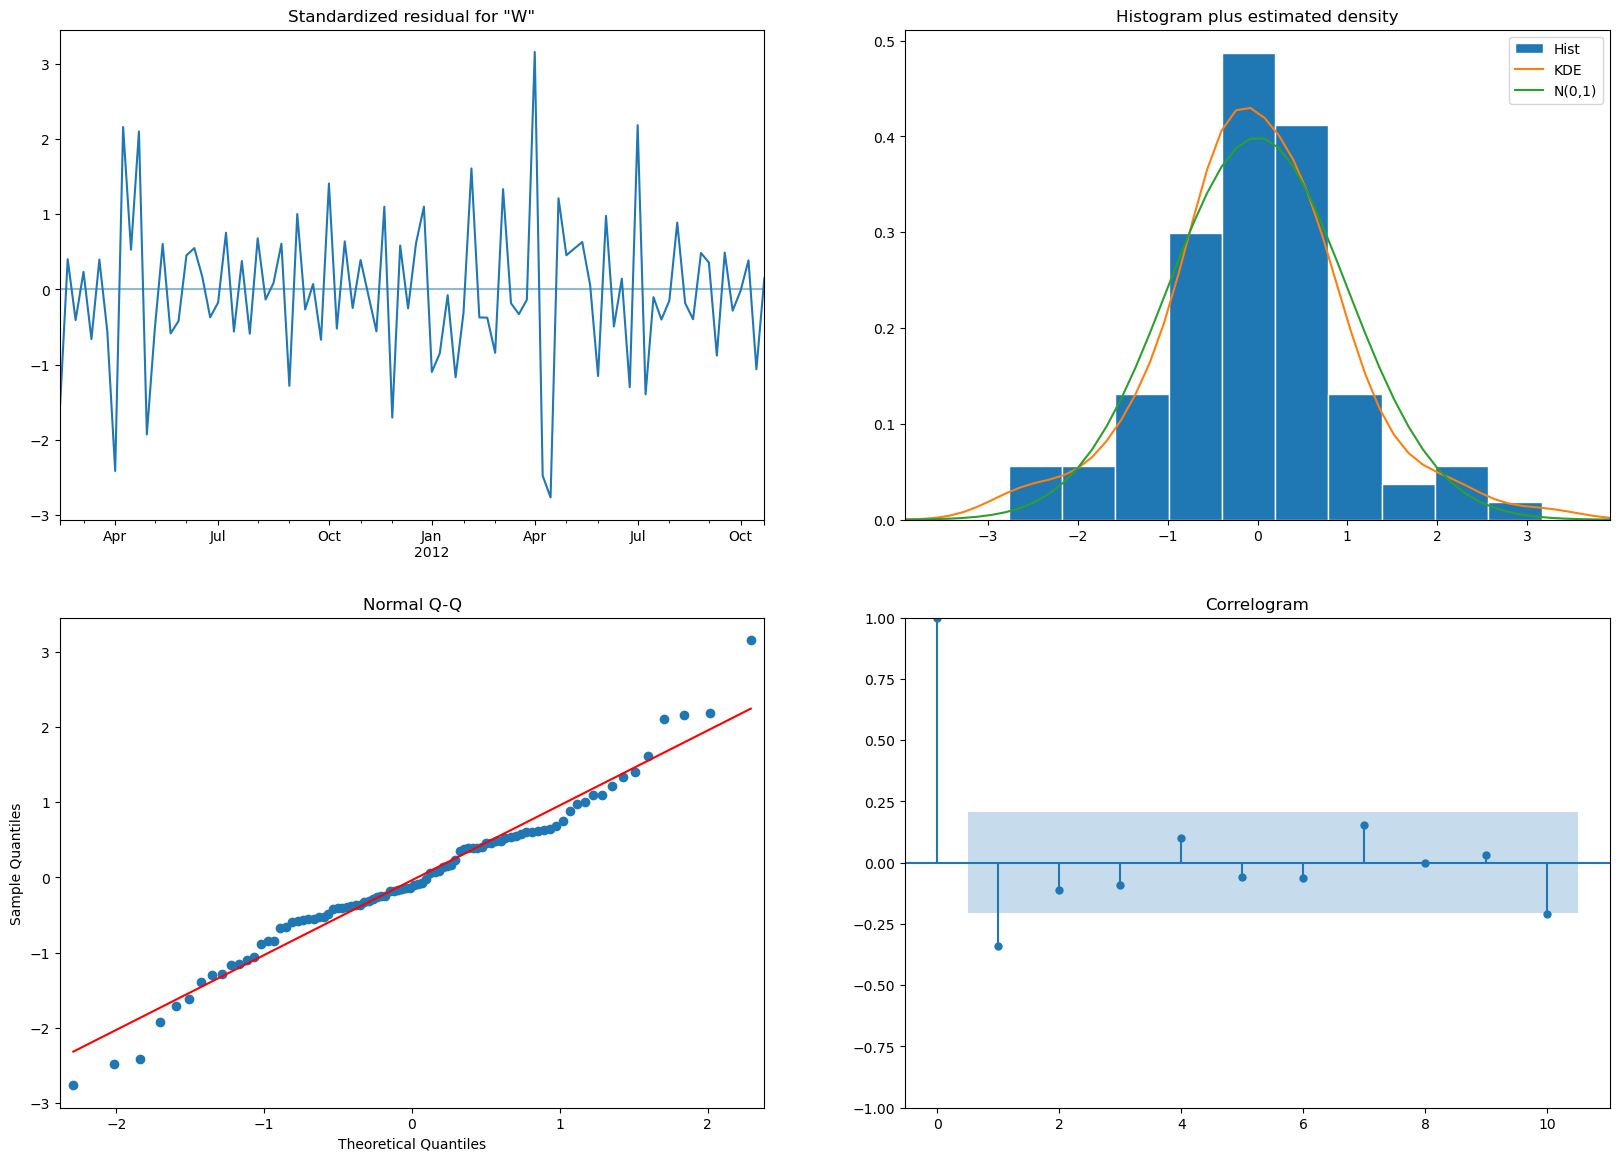

In [20]:
result_SA.plot_diagnostics(figsize = (20, 14))
plt.show()

Interpretation:

Top Left Plot:  residuals do not exhibit obvious seasonality.

Top Right Plot:  the residuals are roughly normally distributed.

Bottom Left Plot:  residuals roughly follow the linear trend of samples from a standard normal distribution N(0,1).

Bottom Right Plot:  residuals are uncorrelated.

#### Residual Analysis:

In [21]:
residuals = result_SA.resid
mae = np.mean(np.abs(residuals))
print (mae)

1823280.956777425


##### Interpretation:

### Section 2.4.  In-Sample Prediction and Evaluation

#### 1-Step-Ahead prediction:

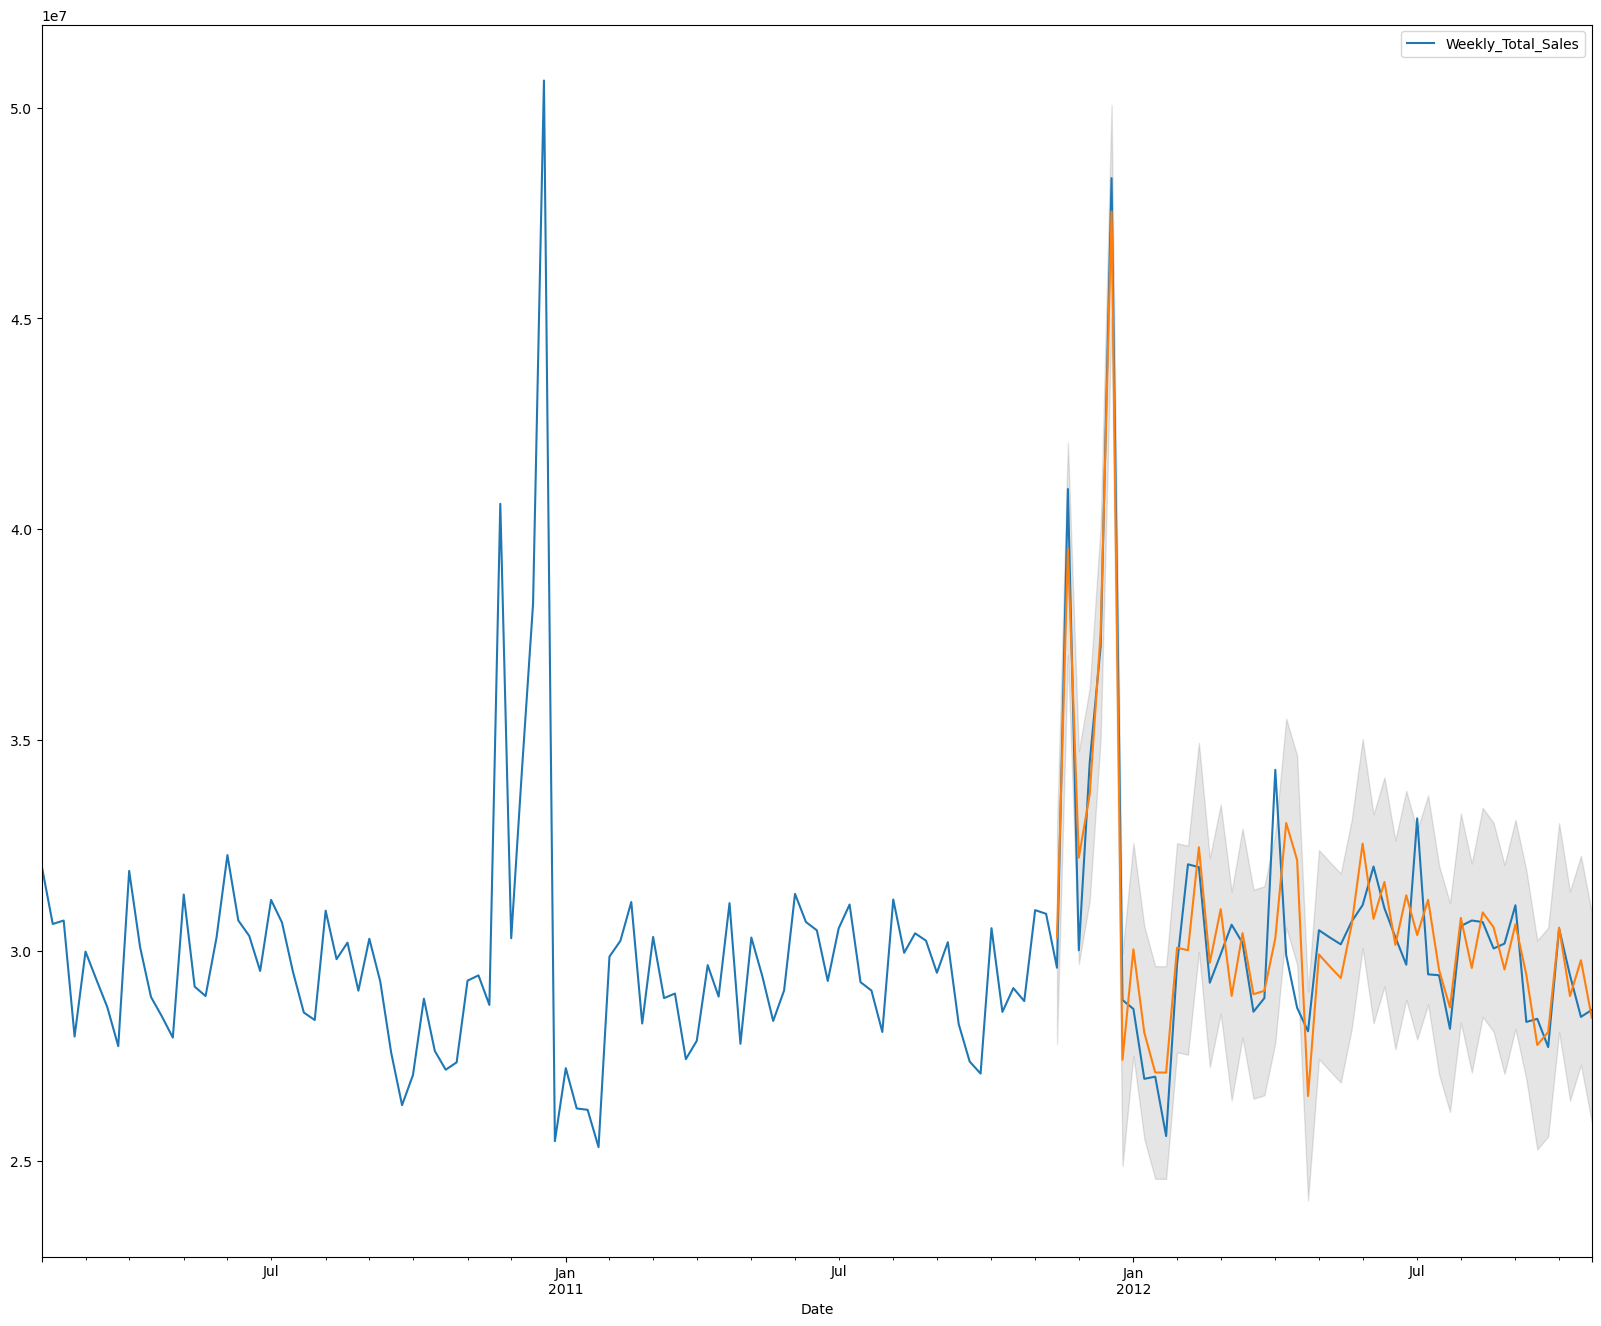

In [26]:
# In-sample 1-STEP-AHEAD prediction for the last 50 time units, compared to original data

predict1 = result_SA.get_prediction(start=-50, dynamic=False)
predict1_ci = predict1.conf_int()

ax3 = df_sums_typeA.plot(figsize=(20, 16))
predict1.predicted_mean.plot(ax=ax3, label='1-Step-Ahead')
ax3.fill_between(predict1_ci.index, predict1_ci.iloc[:, 0], predict1_ci.iloc[:, 1], color='k', alpha=.1)
plt.show()

##### Observations: 

Evaluation of the SARIMA 1-step-ahead prediction

In [53]:

true_vals = df_sums_typeA[-50:].values
predict1_vals = predict1.predicted_mean.values

mae = mean_absolute_error(predict1_vals, true_vals)
rmse = np.sqrt(mean_squared_error(predict1_vals, true_vals))
mape = np.mean(np.abs((predict1_vals - true_vals) / true_vals)) *100
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 1011777.54
Root Mean Squared Error (RMSE): 1349026.15
Mean Absolute Percentage Error (MAPE): 9.21%


### Section 2.5.  Dynamic Prediction

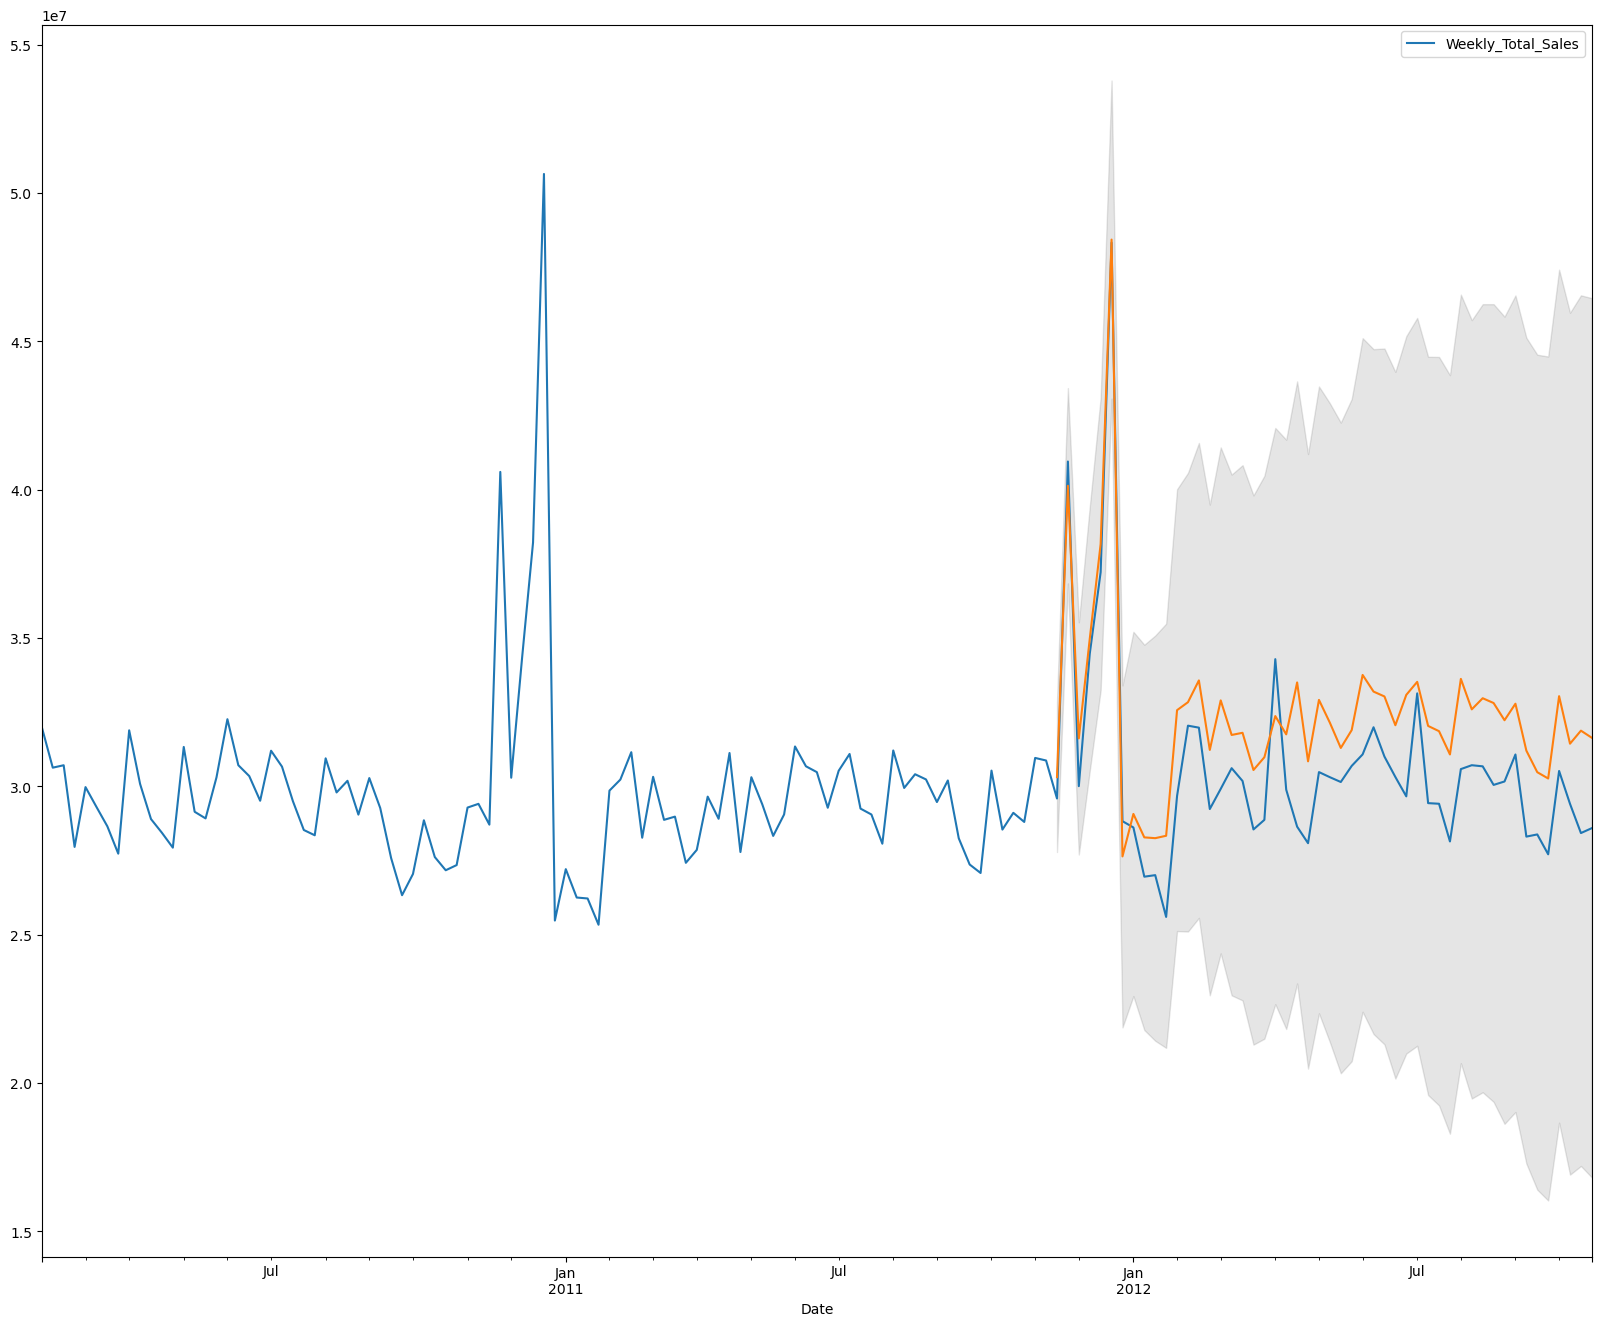

In [23]:
# In-sample DYNAMIC prediction for the last 50 weeks, compared to original data

predict2 = result_SA.get_prediction(start=-50, dynamic=True)
predict2_ci = predict2.conf_int()

ax3 = df_sums_typeA.plot(figsize=(20, 16))
predict2.predicted_mean.plot(ax=ax3, label='Dynamic')
ax3.fill_between(predict2_ci.index, predict2_ci.iloc[:, 0], predict2_ci.iloc[:, 1], color='k', alpha=.1)
plt.show()

### Section 2.6.  Part Summary

## <u>Part III.  SARIMAX Modeling with Exogenous Variables</u>


A SARIMAX model adds more to the SARIMA model, incorporating exogenous variables. These can be obtained from our set of features, used in a linear regression, and integrated into the SARIMAX model to improve forecasting accuracy.

We bring back the "features" dataframe to extract features.

#### Section 3.1.  Exploring Features

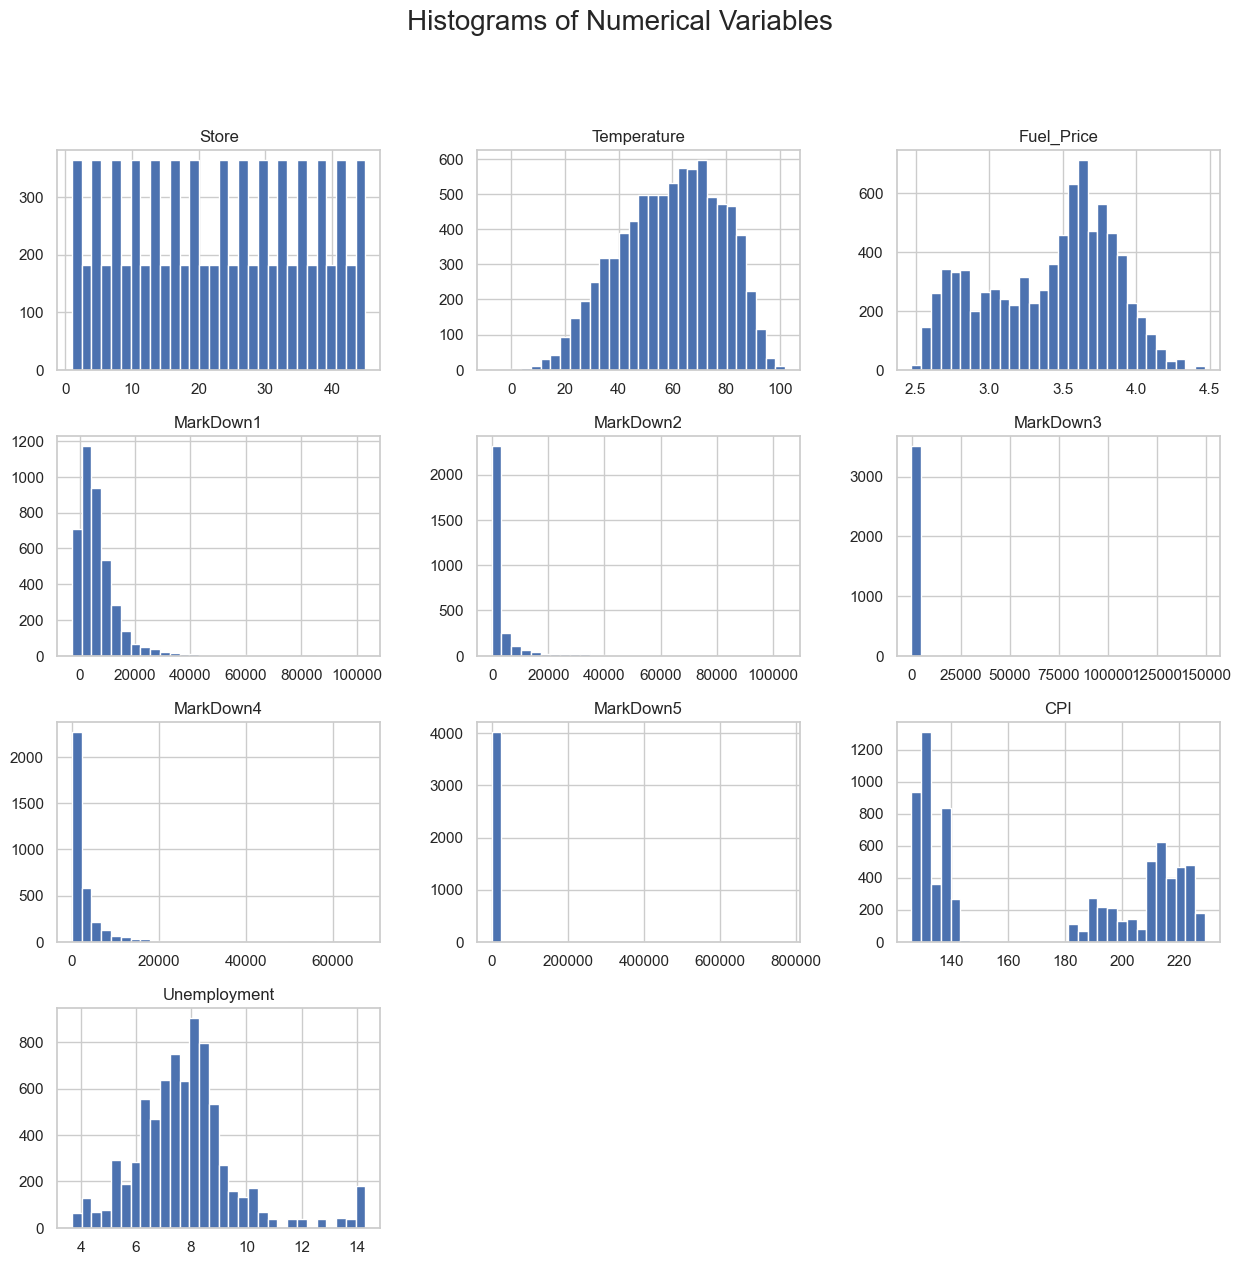

In [51]:
# Display statistical summary
# print(df_features.describe())
# Check for missing values
# print(df_features.isnull().sum())

sns.set(style="whitegrid")

# Plot histograms for numerical variables
df_features.hist(bins=30, figsize=(15, 14))
plt.suptitle('Histograms of Numerical Variables', fontsize=20)
plt.show()

#### Preparing Features

In [77]:
#df_features['CPI'].fillna(df_features['CPI'].median(),inplace=True)
#df_features['Unemployment'].fillna(df_features['Unemployment'].median(),inplace=True)

In [19]:
# create a copy dataframe keeping only useful features
df_exog = df_features[['Date','Store','Temperature','Fuel_Price','CPI','Unemployment']].copy()
# converting 'Date' column to datetime format

df_exog['Date'] = pd.to_datetime(df_exog['Date'])
df_exog.set_index('Date', inplace=True)



In [20]:
# merge exog dataframe onto the typeA target departments
df_typeA_target_exog = pd.merge(df_exog, df_typeA_target, on=['Store', 'Date'], how='inner')
df_typeA_target_exog.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday,Type,Size,StoreDept
Date,,,,,,,,,,,
2010-02-05,1,42.31,2.572,211.096358,8.106,1,24924.50,False,A,151315,S1D1
2010-02-05,1,42.31,2.572,211.096358,8.106,2,50605.27,False,A,151315,S1D2
2010-02-05,1,42.31,2.572,211.096358,8.106,3,13740.12,False,A,151315,S1D3
2010-02-05,1,42.31,2.572,211.096358,8.106,4,39954.04,False,A,151315,S1D4
2010-02-05,1,42.31,2.572,211.096358,8.106,5,32229.38,False,A,151315,S1D5


Examining correlation between Weekly Sales and other features

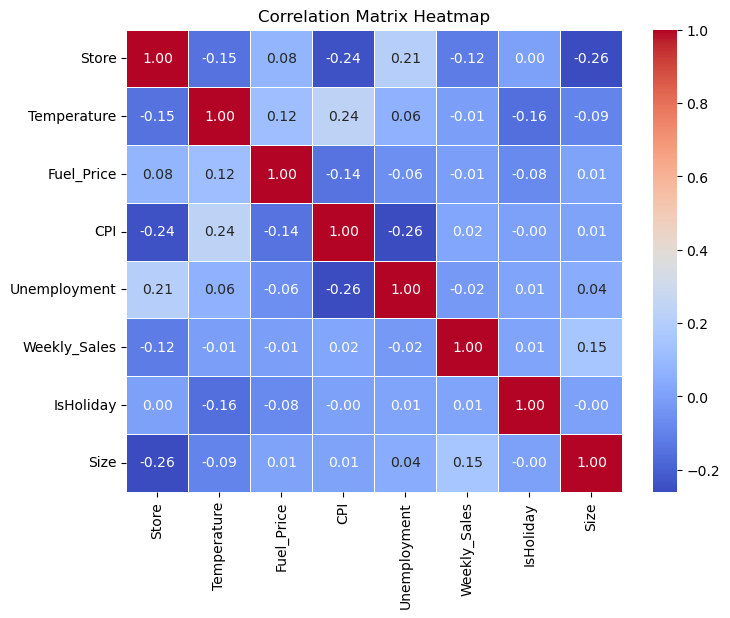

In [44]:
# Calculate the correlation matrix
df_for_corr = df_typeA_target_exog[['Store','Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales','IsHoliday','Size']]

corr_matrix = df_for_corr.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,      # Show the correlation values on the heatmap
    cmap='coolwarm', # Choose a colormap (e.g., 'coolwarm', 'viridis', 'plasma')
    fmt=".2f",       # Format annotations to two decimal places
    linewidths=.5    # Add lines between cells for better visual separation
)
plt.title('Correlation Matrix Heatmap')
plt.show()

Instead of adding all potential exogenous variables together as a 2-D array, we add them one by one to test their contribution to our model's fit.
With the addition of each exogenous variable, we repeat the process from previous sections 2.2 to 2.4 to estimate parameters, fit model, make in-sample prediciton with evaluation.

### Section 3.2. Adding "Holiday"

create a seperate dataframe for "holiday" as exogenous variable

In [21]:
# find average value of 'IsHoliday' to all 1399 target departments in each week.
means_holiday = df_typeA_target_exog.groupby('Date')['IsHoliday'].mean()
df_checked_holiday = means_holiday.to_frame()
#by taking means and checking value counts, we make sure there are only values 1 and 0 for IsHoliday.
#df_checked_holiday.value_counts()

df_checked_holiday.rename(columns = {'IsHoliday': 'Checked_Holiday'},inplace=True)
#df_checked_holiday.plot()

Auto arima grid search with holiday added:

In [41]:
auto_arima_d1_holiday = pmd.auto_arima(df_sums_typeA,
                                    X=df_checked_holiday,  # 'X' is the updated arg, 'exogenous' is outdated.
                                    d=1,
                                    start_p=1,  # it seems starting at 0 is the same as 1?
                                    start_q=1,
                                    max_p=3,
                                    max_q=3,
                                    seasonal=True,
                                    m=52,
                                    D=1,
                                    start_P=1,
                                    start_Q=1,
                                    max_P=3,
                                    max_Q=3,
                                    information_criterion='aic',  # aic is better than bic for predictive models
                                    trace=True,    # print results while training
                                    stepwise=True    # apply intelligent order search
                                    )
print(auto_arima_d1_holiday.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Time=29.43 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3134.771, Time=3.15 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2804.999, Time=6.79 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2803.530, Time=9.26 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2814.334, Time=3.03 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=26.01 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2795.887, Time=31.95 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=2797.886, Time=19.68 sec
 ARIMA(0,1,1)(0,1,3)[52]             : AIC=2797.886, Time=56.49 sec
 ARIMA(0,1,1)(1,1,3)[52]             : AIC=2799.886, Time=38.25 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=2805.217, Time=47.54 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=2797.534, Time=37.91 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=2798.721, Time=25.03 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=2797.716, Time=14.77 sec
 ARIMA(1,1,2)(0,1,2

fit the SARIMAX model with holiday as exogenous variable:

C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


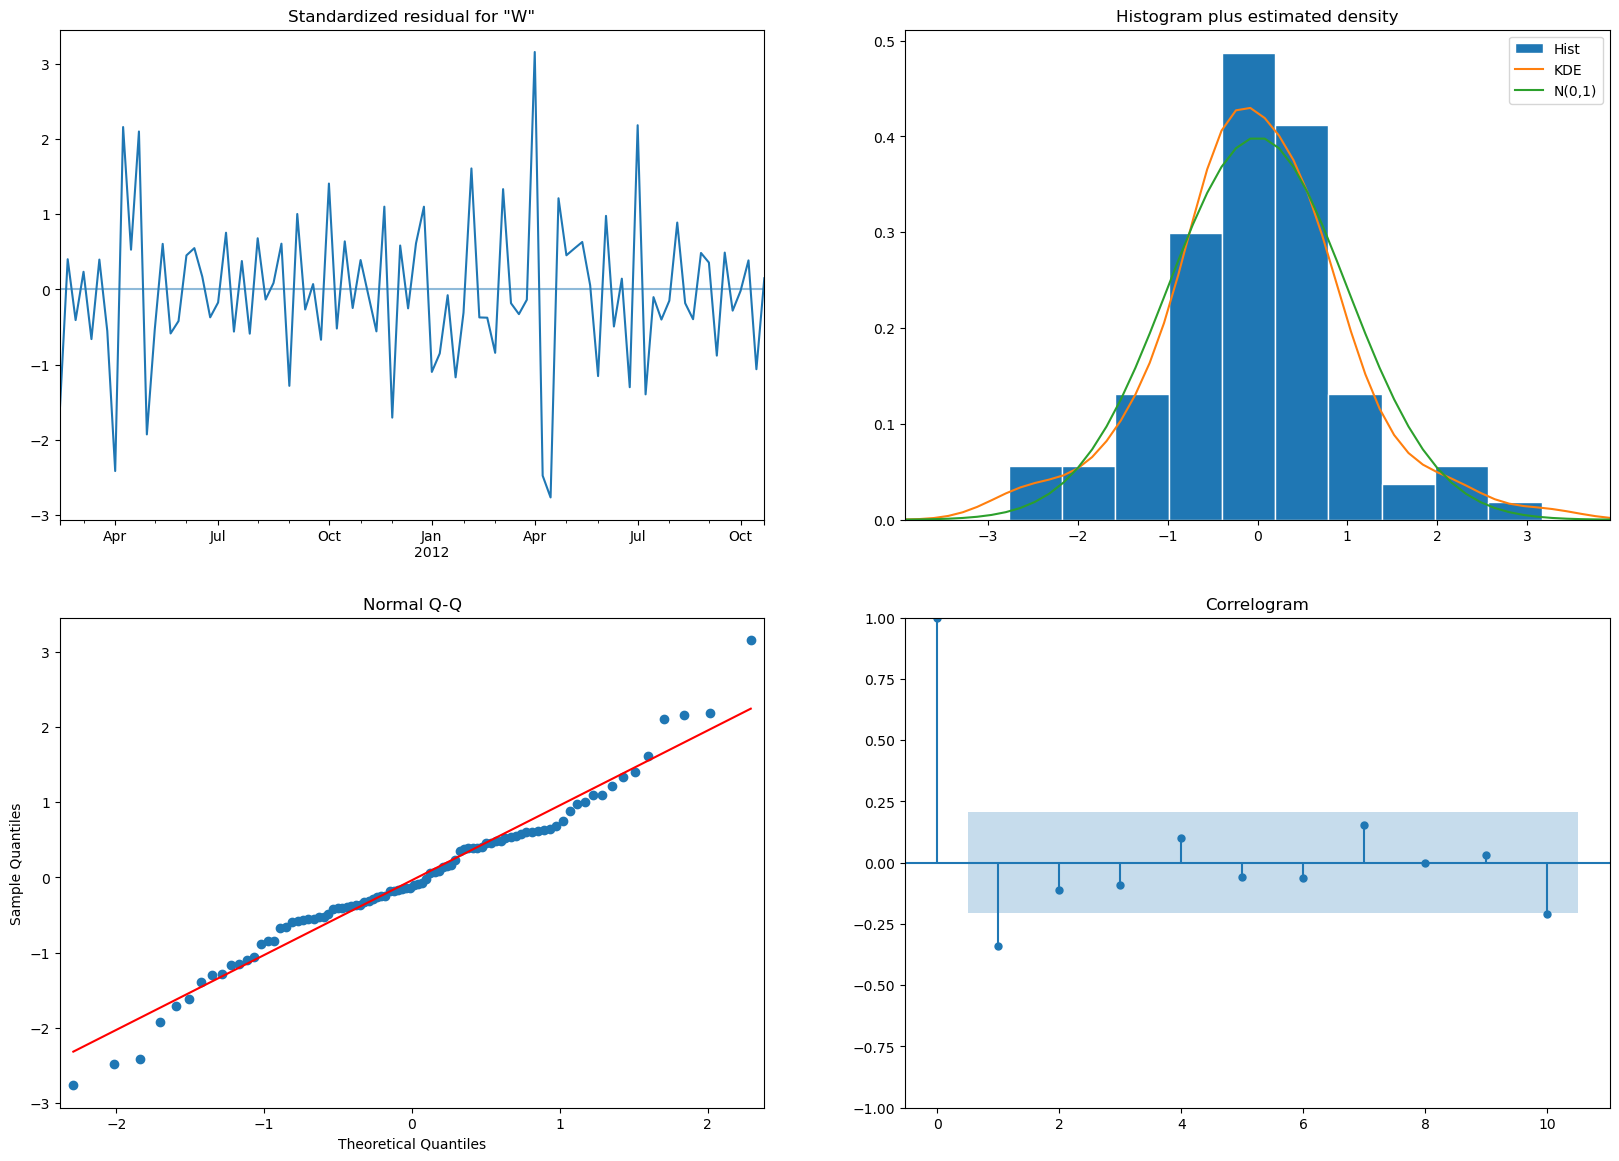

In [22]:
model_sums_typeA_holiday = SARIMAX(df_sums_typeA, exog=df_checked_holiday, order=(0,1,1), seasonal_order = (0,1,2,52))
result_SAX_holiday = model_sums_typeA_holiday.fit()
result_SAX_holiday.plot_diagnostics(figsize = (20, 14))
plt.show()

Checking Residuals:

In [68]:
residual_hol = result_SAX_holiday.resid
mae_residual_hol = np.mean(np.abs(residual_hol))
print (mae_residual_hol)

1823280.9567888489


In sample prediction:

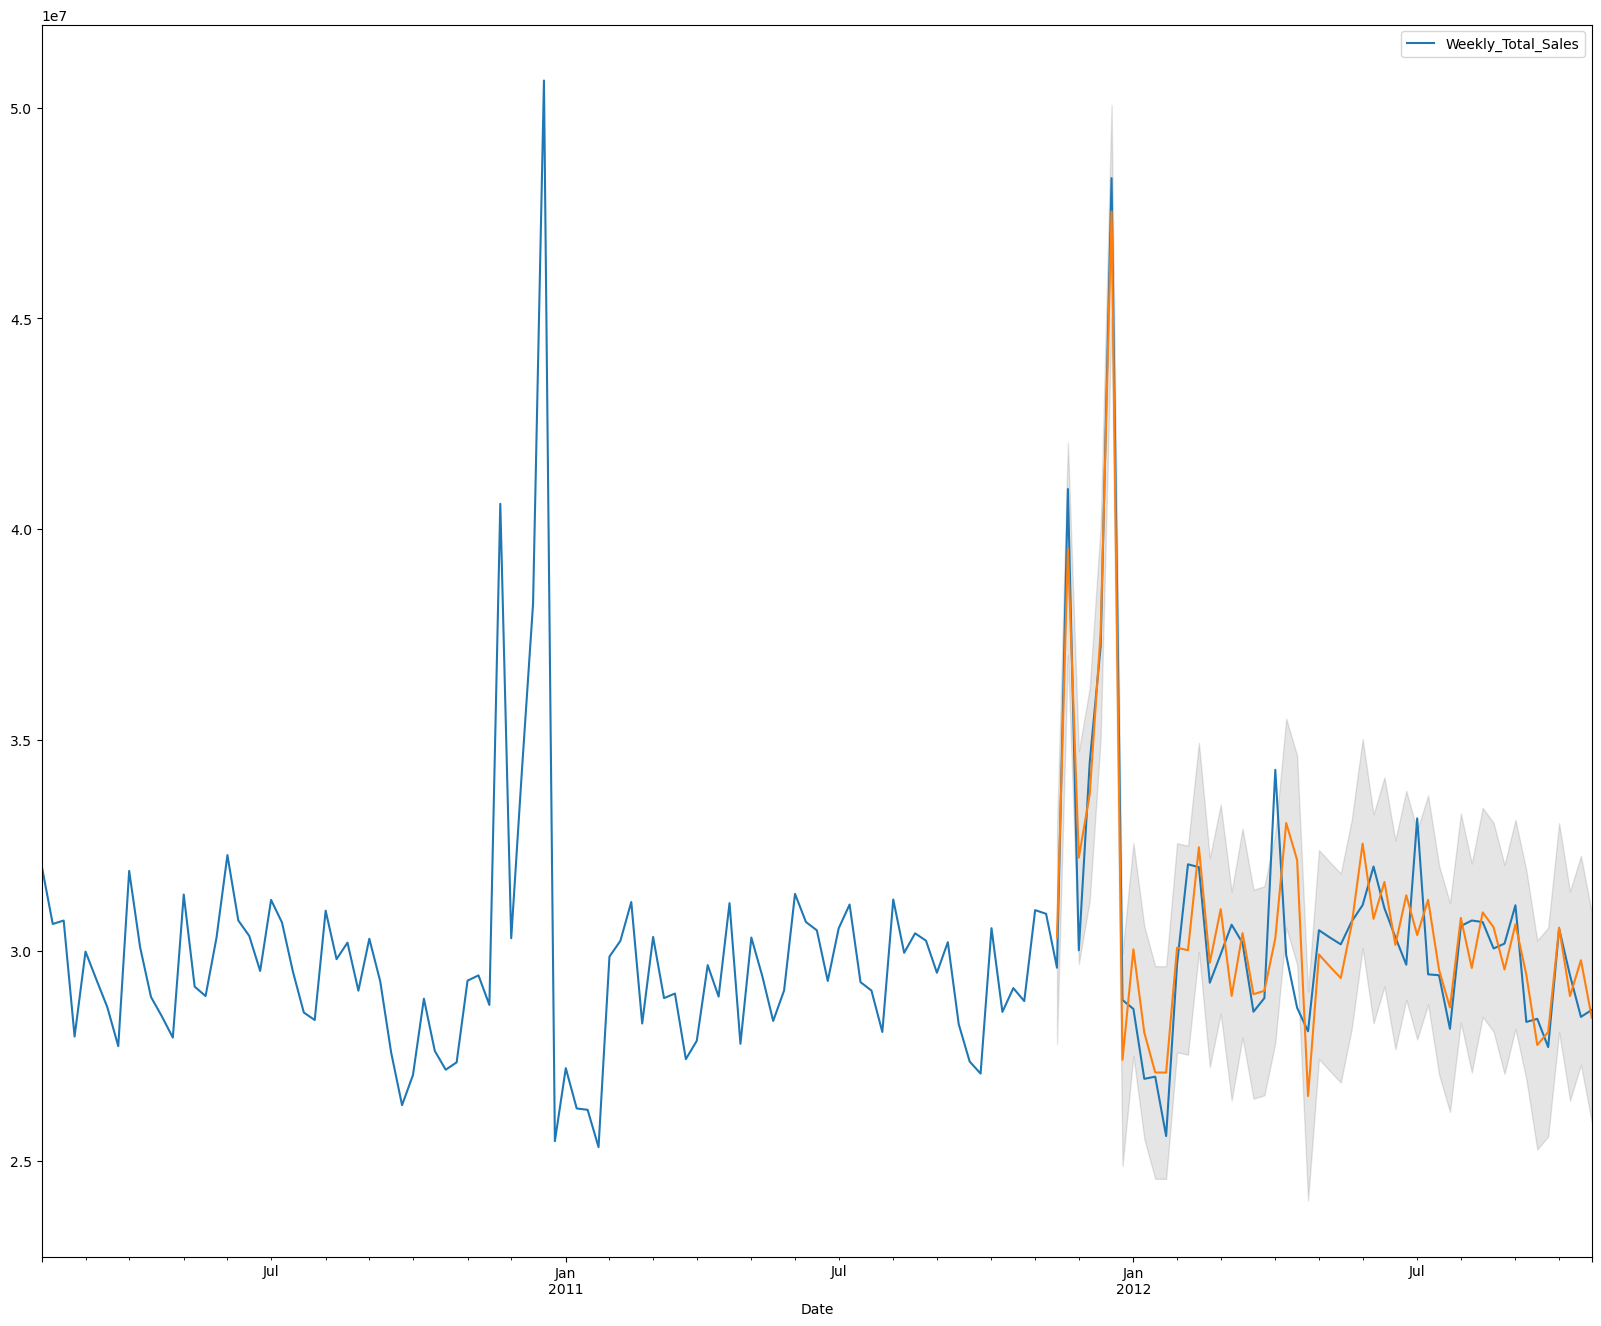

In [62]:
# In-sample 1-STEP-AHEAD prediction for the last 50 time units, compared to original data

predict_hol_1 = result_SAX_holiday.get_prediction(start=-50, dynamic=False)
predict_hol_1_ci = predict_hol_1.conf_int()

ax3 = df_sums_typeA.plot(figsize=(20, 16))
predict_hol_1.predicted_mean.plot(ax=ax3, label='1-Step-Ahead')
ax3.fill_between(predict_hol_1_ci.index, predict_hol_1_ci.iloc[:, 0], predict_hol_1_ci.iloc[:, 1], color='k', alpha=.1)
plt.show()

Evaluation of the SARIMAX with holiday 1-step-ahead prediction

In [63]:

true_vals = df_sums_typeA[-50:].values
predict_hol_1_vals = predict_hol_1.predicted_mean.values

mae_hol = mean_absolute_error(predict_hol_1_vals, true_vals)
rmse_hol = np.sqrt(mean_squared_error(predict_hol_1_vals, true_vals))
mape_hol = np.mean(np.abs((predict_hol_1_vals - true_vals) / true_vals)) *100
print(f"Mean Absolute Error (MAE): {mae_hol:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hol:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_hol:.2f}%")


Mean Absolute Error (MAE): 1011777.54
Root Mean Squared Error (RMSE): 1349026.15
Mean Absolute Percentage Error (MAPE): 9.21%


### Observations:
adding holiday as exogenous variable did not make any change to our prediction.

### Section 3.3. Adding "Fuel_Price"

create a seperate dataframe for "fuel price" as exogenous variable
We use each date's average fuel price among store locations 

<Axes: xlabel='Date'>

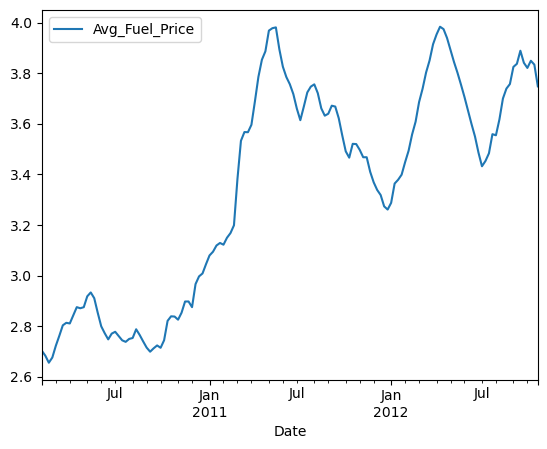

In [72]:
# find average value of 'Fuel_Price' to all 1399 target departments in each week.
means_fuel = df_typeA_target_exog.groupby('Date')['Fuel_Price'].mean()
df_means_fuel = means_fuel.to_frame()
df_means_fuel.rename(columns = {'Fuel_Price': 'Avg_Fuel_Price'},inplace=True)
df_means_fuel.plot()

Auto arima grid search with fuel price added:

In [47]:
auto_arima_d1_fuel = pmd.auto_arima(df_sums_typeA,
                                    X=df_means_fuel,
                                    d=1,
                                    start_p=1,  # it seems starting at 0 is the same as 1?
                                    start_q=1,
                                    max_p=3,
                                    max_q=3,
                                    seasonal=True,
                                    m=52,
                                    D=1,
                                    start_P=1,
                                    start_Q=1,
                                    max_P=3,
                                    max_Q=3,
                                    information_criterion='aic',  # aic is better than bic for predictive models
                                    trace=True,    # print results while training
                                    stepwise=True    # apply intelligent order search
                                    )
print(auto_arima_d1_fuel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=inf, Time=35.32 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3134.690, Time=3.68 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2803.794, Time=6.78 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=2802.001, Time=8.41 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=2813.468, Time=1.87 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=21.28 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=2795.285, Time=17.93 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=2797.284, Time=19.92 sec
 ARIMA(0,1,1)(0,1,3)[52]             : AIC=2797.283, Time=71.31 sec
 ARIMA(0,1,1)(1,1,3)[52]             : AIC=2799.283, Time=37.59 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=2805.245, Time=58.52 sec
 ARIMA(1,1,1)(0,1,2)[52]             : AIC=2796.978, Time=38.35 sec
 ARIMA(0,1,2)(0,1,2)[52]             : AIC=2798.173, Time=23.55 sec
 ARIMA(1,1,0)(0,1,2)[52]             : AIC=2797.304, Time=16.23 sec
 ARIMA(1,1,2)(0,1,2

fit the SARIMAX model with fuel price as exogenous variable:

C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\steve\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


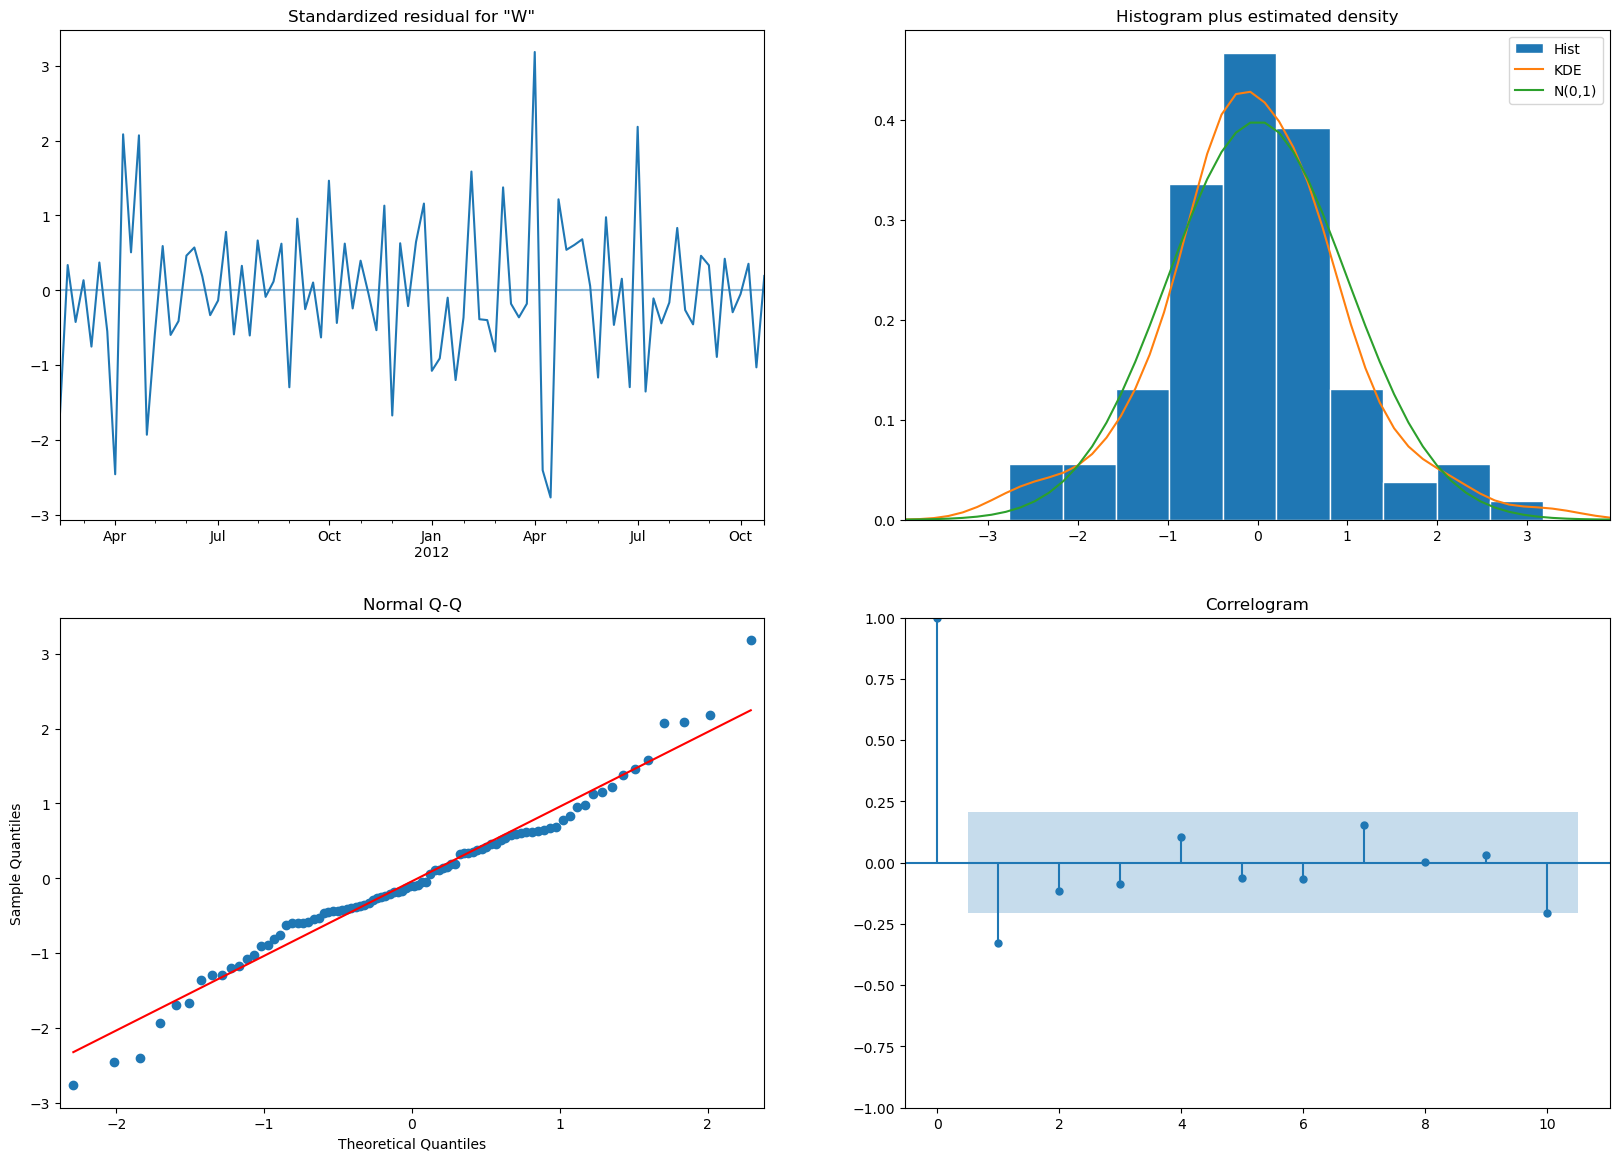

In [64]:
model_sums_typeA_fuel = SARIMAX(df_sums_typeA, exog=df_means_fuel, order=(0,1,1), seasonal_order = (0,1,2,52))
result_SAX_fuel = model_sums_typeA_fuel.fit()
result_SAX_fuel.plot_diagnostics(figsize = (20, 14))
plt.show()

check residuals:

In [67]:
residual_fuel = result_SAX_fuel.resid
mae_residual_fuel = np.mean(np.abs(residual_fuel))
print (mae_residual_fuel)

1797602.1566044746


in-sample prediction:

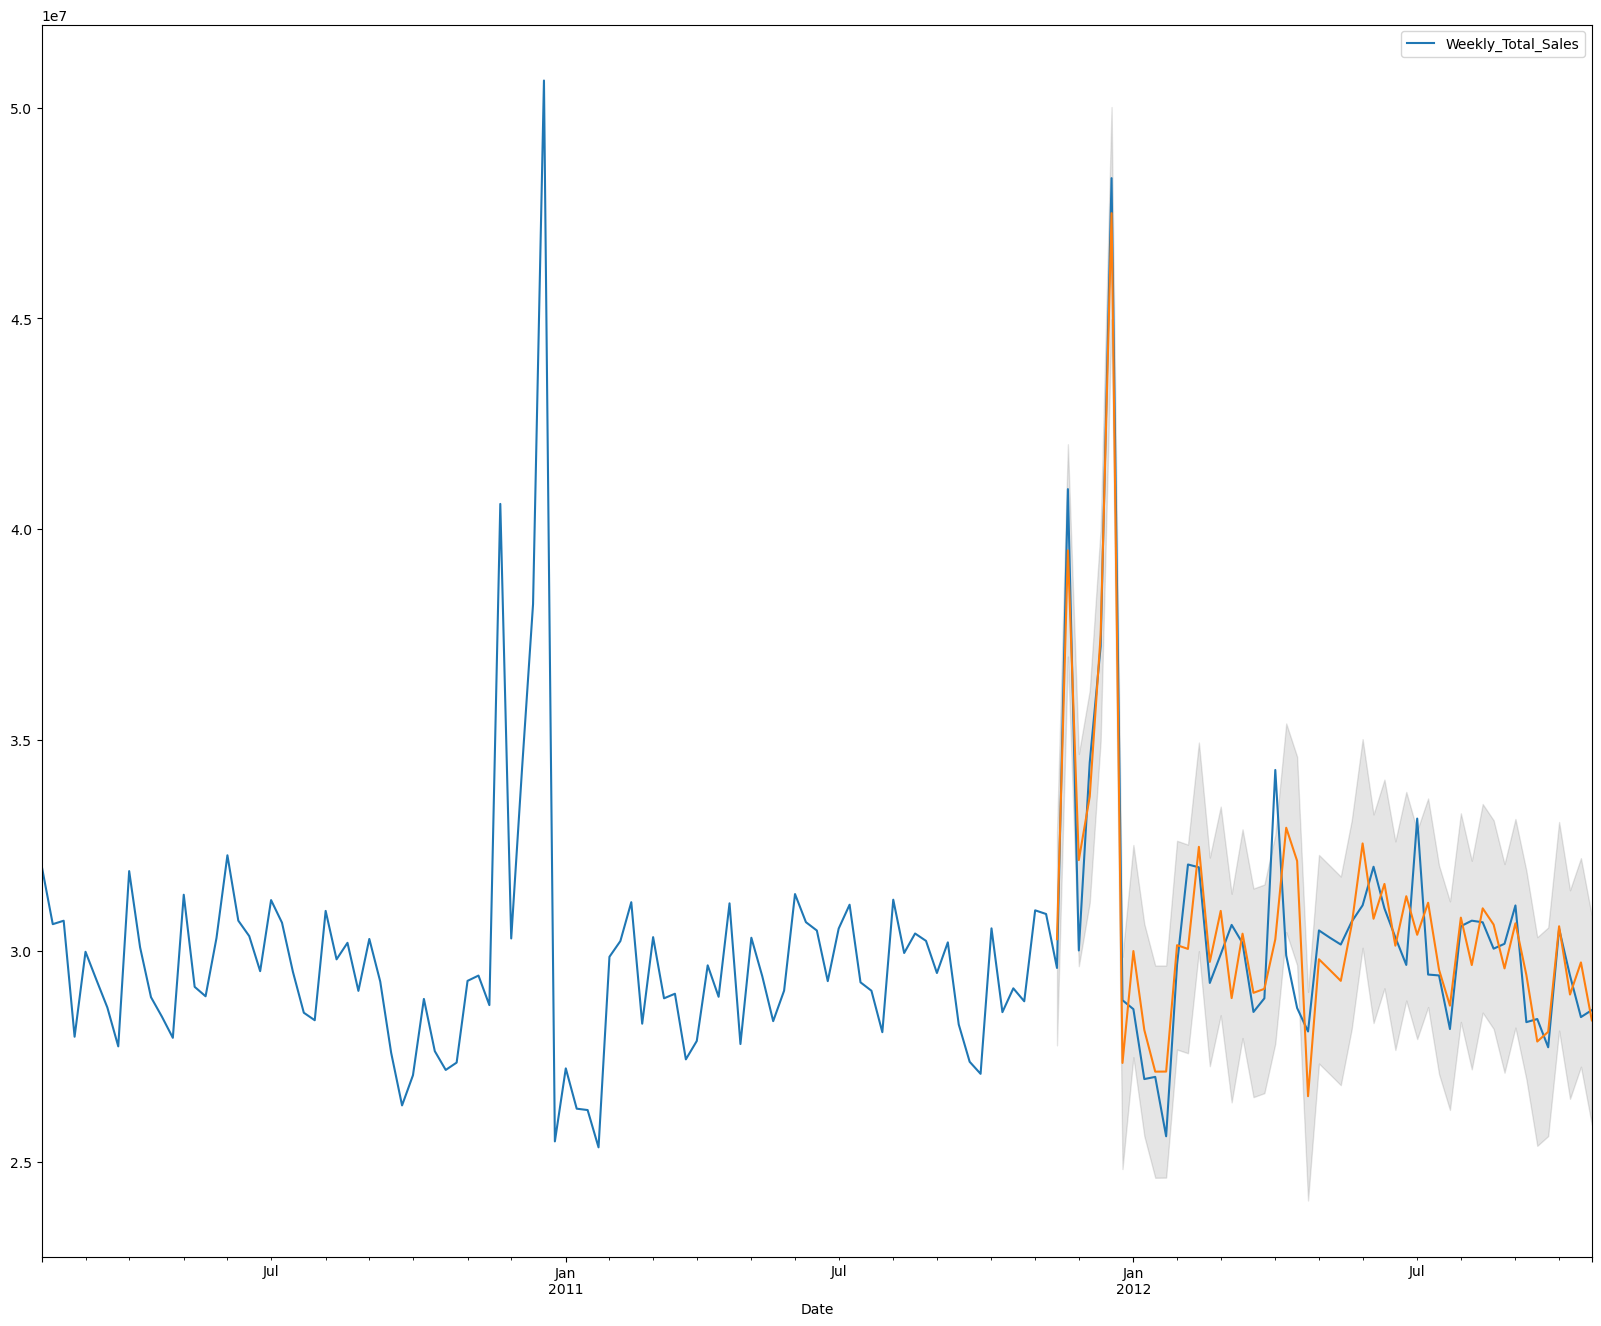

In [65]:
# In-sample 1-STEP-AHEAD prediction for the last 50 time units, compared to original data

predict_fuel_1 = result_SAX_fuel.get_prediction(start=-50, dynamic=False)
predict_fuel_1_ci = predict_fuel_1.conf_int()

ax3 = df_sums_typeA.plot(figsize=(20, 16))
predict_fuel_1.predicted_mean.plot(ax=ax3, label='1-Step-Ahead')
ax3.fill_between(predict_fuel_1_ci.index, predict_fuel_1_ci.iloc[:, 0], predict_fuel_1_ci.iloc[:, 1], color='k', alpha=.1)
plt.show()

Evaluation of the SARIMAX with fuel 1-step-ahead prediction

In [66]:

true_vals = df_sums_typeA[-50:].values
predict_fuel_1_vals = predict_fuel_1.predicted_mean.values

mae_fuel = mean_absolute_error(predict_fuel_1_vals, true_vals)
rmse_fuel = np.sqrt(mean_squared_error(predict_fuel_1_vals, true_vals))
mape_fuel = np.mean(np.abs((predict_fuel_1_vals - true_vals) / true_vals)) *100
print(f"Mean Absolute Error (MAE): {mae_fuel:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_fuel:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fuel:.2f}%")


Mean Absolute Error (MAE): 1018798.26
Root Mean Squared Error (RMSE): 1344753.64
Mean Absolute Percentage Error (MAPE): 9.19%


exogenous variable "CPI" should be detrended before using?

## <u>Part IV.  Forecasting Out of Sample</u>

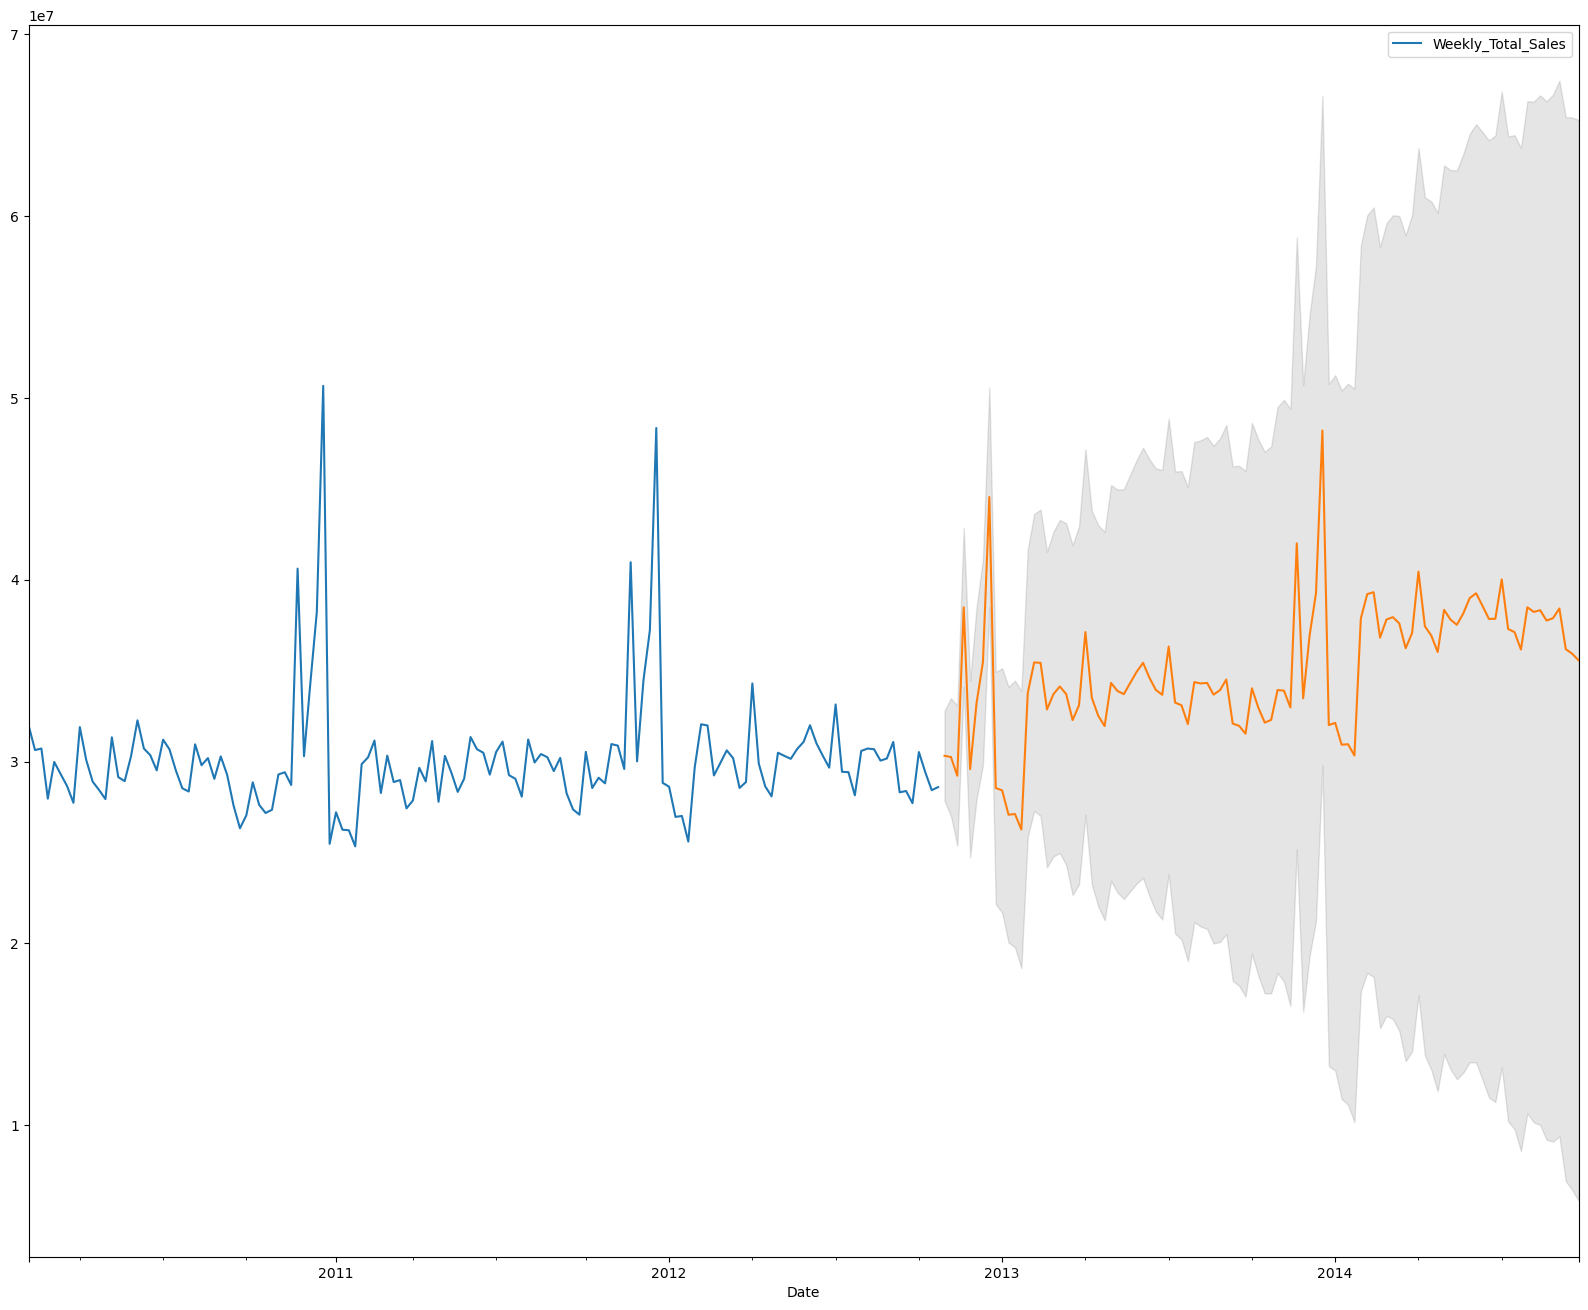

In [25]:

ax3 = df_sums_typeA.plot(figsize=(20, 16))
forecast1 = result_SA.get_forecast(steps=100)
forecast1.predicted_mean.plot(ax=ax3, label='Dynamic')
forecast1_ci = forecast1.conf_int()
ax3.fill_between(forecast1_ci.index, forecast1_ci.iloc[:, 0], forecast1_ci.iloc[:, 1], color='k', alpha=.1)
plt.show()